In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
from functools import partial

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import optax
import jaxopt
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from infiniteDoob.networks import ScoreMLP
from infiniteDoob import landmarks, metric, Eulerian
from infiniteDoob import plotting
from infiniteDoob.utils import integrate_sde, integrator_ito, dts

In [42]:
key = jax.random.PRNGKey(32)

config = {
        "n_landmarks": 64,
        "landmark_kernel_amplitude": 1.0,
        "landmark_kernel_sigma": 0.2,
        "landmark_kernel_trucation": 3.0,
        "noise_field_size": 3.0,
        "noise_field_discretization_resolution": 128,
        "n_steps": 100,
        "T": 0.1,
        "learning_rate": 0.001,
        "epochs": 100,
        "batch_size": 16,
        "n_batches_per_epoch": 50,
    }

In [19]:
def setup_manifold(config):
    M = landmarks.Landmarks(N=config["n_landmarks"], m=2)
    metric.initialize(M)
    Eulerian.initialize(M)

    return M

def downsample_circle(M, key=None, random=False):
    if random:
        assert key is not None
        phis = jax.random.uniform(key, (M.N,), minval=0., maxval=2.0*jnp.pi)
    else:
        phis = jnp.linspace(0., 2.0*jnp.pi, M.N)
        phis = jnp.sort(phis)

    return M.coords(jnp.vstack([jnp.cos(phis),
                                jnp.sin(phis)]).T.ravel())

def setup_sde(config, M):
    # Set up the Gaussian kernel
    EDGE_Q = config["noise_field_size"] / 2.0
    DELTA_X = config["noise_field_size"] / config["noise_field_discretization_resolution"]
    AMP_Q = config["landmark_kernel_amplitude"]
    SCALE_Q = config["landmark_kernel_sigma"]

    KERNEL_EDGE_Q = config["landmark_kernel_trucation"] * SCALE_Q
    KERNEL_EDGE_X = KERNEL_EDGE_Q / DELTA_X
    KERNEL_DIM = int(2.0 * KERNEL_EDGE_X + 1.0)
    KERNEL_SPAN_X = jnp.linspace(-KERNEL_EDGE_X, KERNEL_EDGE_X, KERNEL_DIM)
    print(f"Kernel Dimension: {KERNEL_DIM} x {KERNEL_DIM}")

    # Coordinates transformation
    q_to_x = lambda q: (q + EDGE_Q) / DELTA_X

    # Set up the convolution on pixel grid
    gaussian = lambda span, scale: jnp.exp(-1.0 * (span / scale)**2)
    k_Q_half = lambda amp_x, scale_x: amp_x * gaussian(span=KERNEL_SPAN_X, scale=scale_x) * gaussian(span=KERNEL_SPAN_X[:, None], scale=scale_x)
    Q_half_dW = jax.vmap(
        jax.vmap(
            lambda amp_q, scale_q, _dW: jsp.signal.convolve(_dW, 
                                                            k_Q_half(amp_x=amp_q*DELTA_X, 
                                                                     scale_x=scale_q/DELTA_X), 
                                                            mode='same'),
            (None, None, 2),
            2
        ),
        (None, None, 0),
        0
    )
    interpolate = jax.vmap(
        lambda _Q_half_dW, q: jsp.ndimage.map_coordinates(_Q_half_dW.T, q_to_x(q).T, order=1),
        (2, None),
        1
    )

    # Theortical covariance for score matching
    k_Q = lambda disp_q, amp_q, scale_q: 0.5 * amp_q**2 * scale_q**2 * jnp.pi * jnp.exp(-0.5 / scale_q**2 * jnp.sum(jnp.square(disp_q), 2))
    k_Q_q = lambda q1, q2, amp_q, scale_q: k_Q(disp_q=q1.reshape((-1, M.m))[:, np.newaxis, :]-q2.reshape((-1, M.m))[np.newaxis, :, :], \
                                               amp_q=amp_q, \
                                               scale_q=scale_q) 
    make_square = lambda A: A.reshape((jnp.sqrt(A.size).astype('int'), jnp.sqrt(A.size).astype('int'))) 
    Q = lambda q, amp_q, scale_q: make_square(jnp.einsum('ij,kl->ikjl', k_Q_q(q1=q, q2=q, amp_q=amp_q, scale_q=scale_q), jnp.eye(2)))  

    def sde_Eulerian_inf_dim_noise(c, y):
        _, q, _ = c
        _, sqrt_Q_dW = y

        X = None
        det = jnp.zeros_like(q)
        sto = interpolate(sqrt_Q_dW, q.reshape((M.N, M.m))).ravel()
        return (det, sto, X)

    Eulerian_q = lambda q, _dts, _dW: integrate_sde(sde_Eulerian_inf_dim_noise, 
                                                    integrator_ito,
                                                    None, 
                                                    q[0], 
                                                    q[1],
                                                    _dts,
                                                    _dW)
    Eulerian_sde = jit(lambda q, amp_q, scale_q, _dts, _dW: Eulerian_q(q=q, _dts=_dts, _dW=Q_half_dW(amp_q, scale_q, _dW))[0: 3])

    return Eulerian_sde, Q

#### One-step Eulerian motion

In [43]:
M = setup_manifold(config)
Eulerian_sde, Q = setup_sde(config, M)
q0 = downsample_circle(M, key=key, random=False)
dW = lambda key: jnp.sqrt(config["T"] / config["n_steps"]) * jax.random.normal(key, (config["n_steps"], config["noise_field_discretization_resolution"], config["noise_field_discretization_resolution"], M.m))  
(ts, qs, charts) = Eulerian_sde(q=q0, 
                           amp_q=config["landmark_kernel_amplitude"], 
                           scale_q=config["landmark_kernel_sigma"], 
                           _dts=dts(T=config["T"], 
                                    n_steps=config["n_steps"]), 
                           _dW=dW(key))

Kernel Dimension: 52 x 52


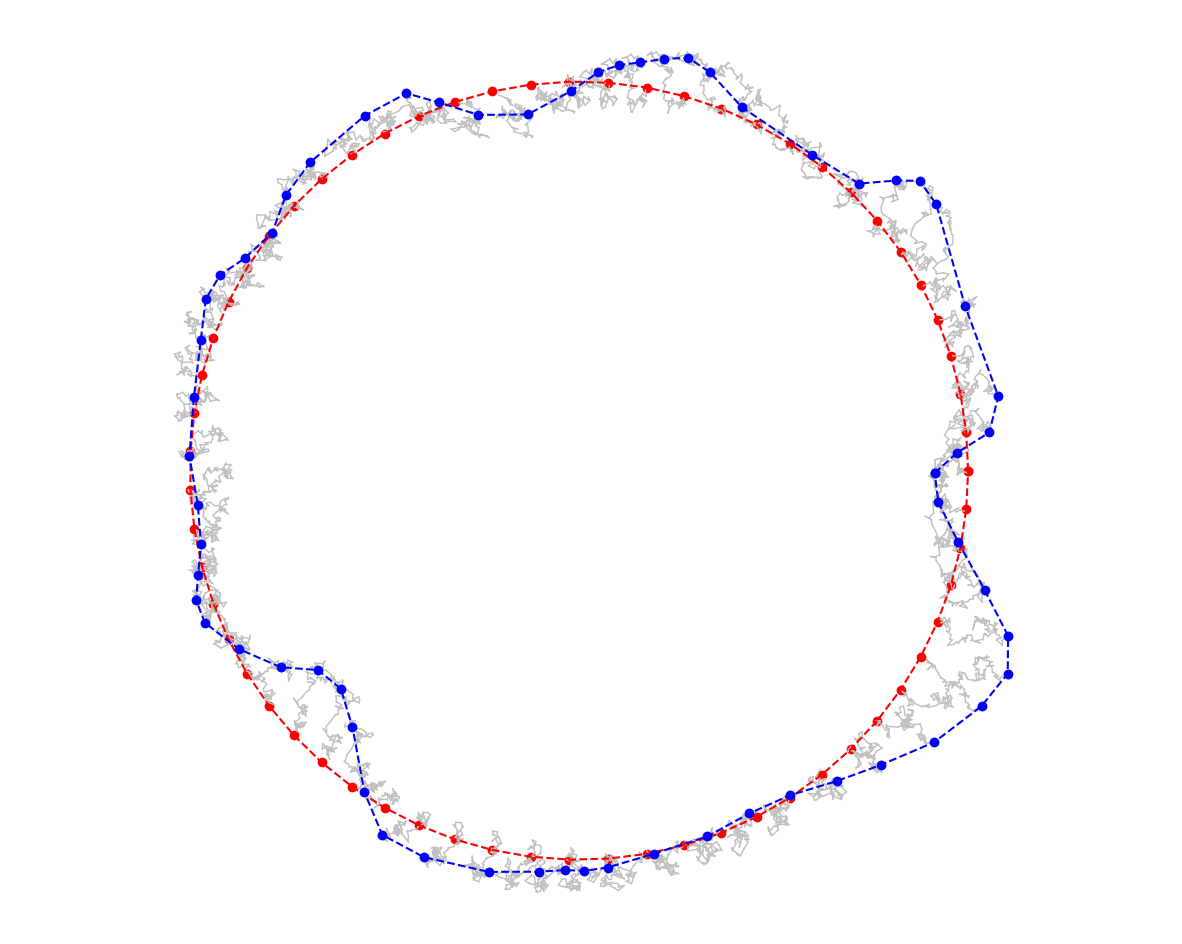

In [50]:
M.plot()
M.plot_path(zip(qs, charts), color='silver', color_intensity=0.1)
M.plotx(q0, color='r', marker='o')
plt.plot(q0[0].reshape((-1, M.m))[:, 0], q0[0].reshape((-1, M.m))[:, 1], color='r', linestyle='--')
plt.plot(qs[-1].reshape((-1, M.m))[:, 0], qs[-1].reshape((-1, M.m))[:, 1], color='b', marker='o', linestyle='--')
plt.gca().set_axis_off()
plt.savefig('./resources/eulerian_dynamics.png', bbox_inches='tight', dpi=300, pad_inches=0)

In [41]:
def train(config=None):
    global key
    global batch_cum_loss
    batch_cum_loss = 0
    print(config)

    n_steps = config["n_steps"]
    T = config["T"]
    amp_q = config["landmark_kernel_amplitude"]
    scale_q = config["landmark_kernel_sigma"]
    noise_field_resolution = config["noise_field_discretization_resolution"]

    learning_rate = config["learning_rate"]
    batch_size = config["batch_size"]
    epochs = config["epochs"]
    n_batches_per_epoch = config["n_batches_per_epoch"]

    M = setup_manifold(config)
    Eulerian_sde, Q = setup_sde(config, M)
    dW = lambda key: jnp.sqrt(T / n_steps) * jax.random.normal(key, (n_steps, noise_field_resolution, noise_field_resolution, M.m))    

    def data_generator():
        global key
        while True:
            qss = []
            for _ in range(batch_size):
                key, _ = jax.random.split(key)
                q0 = downsample_circle(M, key=key, random=False)
                (ts, qs, _) = Eulerian_sde(q=q0, amp_q=amp_q, scale_q=scale_q, _dts=dts(T, n_steps), _dW=dW(key))
                qs = jnp.concatenate((q0[0].reshape((1, -1)), qs), axis=0)
                qss.append(qs)
            qss = jnp.stack(qss)
            yield qss

    ds = tf.data.Dataset.from_generator(data_generator, 
                                        output_types=tf.float32,
                                        output_shapes=[batch_size, int(n_steps+1), M.dim])
    ds = iter(tfds.as_numpy(ds))
    print("Batch shape", next(ds).shape)

    # net = MLP(output_dim=M.dim,
    #     hidden_dims=[256, 256, 256, 256],
    #     activation='elu')
    # params = net.init(key, jnp.zeros((1, M.dim)))

    # def dsm_loss_func(params, data):
    #     (qss, q0s) = data
    #     noises = qss - q0s
    #     sigma = jax.vmap(Q_sigma)(q0s)
    #     inv_sigma = jax.vmap(jnp.linalg.inv, in_axes=0)(sigma)
    #     noise_over_sigma = jax.vmap(jnp.dot, in_axes=0)(noises, inv_sigma)
    #     loss = 0.5 * jnp.mean(jnp.square(net.apply(params, qss) + noise_over_sigma / T))
        
    #     return loss
    
    # def pre_update(params, state, *args, **kwargs):
    #     global batch_cum_loss
    #     batch_cum_loss += state.value
    #     if state.iter_num % n_batches_per_epoch == 0:
    #         print(f"Epoch [{state.iter_num//n_batches_per_epoch+1} / {epochs}]: avg training loss = {batch_cum_loss/n_batches_per_epoch:.4f}")
    #         batch_cum_loss = 0
    #     return params, state
    
    # opt = optax.adam(learning_rate)
    # solver = jaxopt.OptaxSolver(opt=opt,
    #                             fun=dsm_loss_func,
    #                             maxiter=epochs*n_batches_per_epoch,
    #                             pre_update=pre_update)
    
    # state = solver.init_state(params, next(ds))
    # params, state = solver.run_iterator(init_params=params,
    #                                     iterator=ds)
    
    # return params, net
    return ds

In [42]:
ds = train(config)

{'n_landmarks': 64, 'landmark_kernel_amplitude': 0.5, 'landmark_kernel_sigma': 0.05, 'landmark_kernel_trucation': 3.0, 'noise_field_size': 3.0, 'noise_field_discretization_resolution': 128, 'n_steps': 1, 'T': 0.01, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'n_batches_per_epoch': 50}
Kernel Dimension: 13 x 13
Batch shape (16, 2, 128)


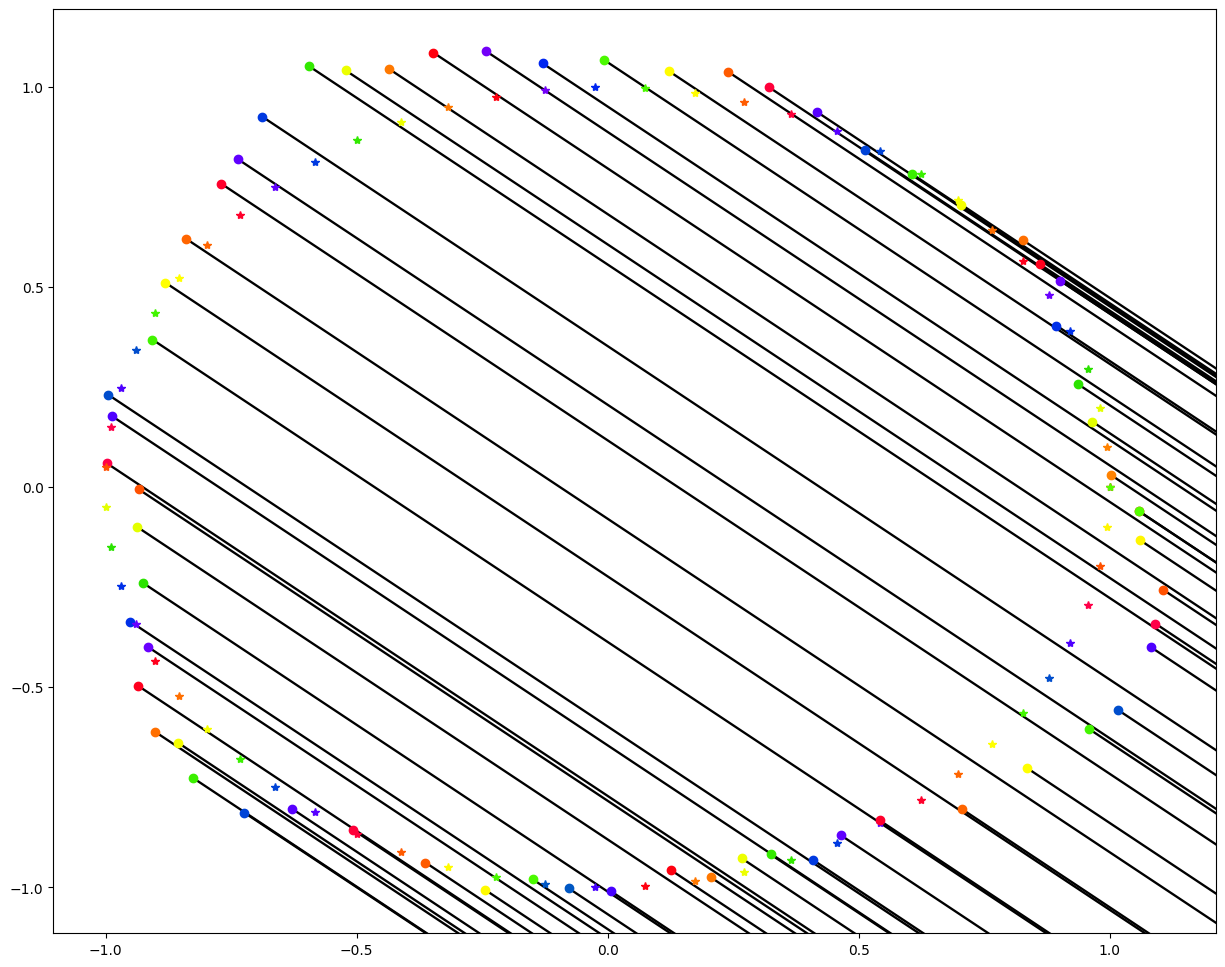

In [31]:
global key
key, _ = jax.random.split(key)
q0 = downsample_shape(M, key=key, random=False)
dW = lambda key: jnp.sqrt(config["T"] / config["n_steps"]) * jax.random.normal(key, (config["n_steps"], M.N, M.N, M.m))
(ts, qs, _) = sde(q0, config["amp"], config["scale"], dts(config["T"], config["n_steps"]), dW(key))
make_square = lambda A: A.reshape((np.sqrt(A.size).astype('int'),np.sqrt(A.size).astype('int')))
kQ = lambda x, amp, scale: 0.5 * amp * scale * jnp.exp(-1./scale**2 *jnp.sum(jnp.square(x), 2))  
# kQ = lambda x, amp, scale: 0.5 * amp * jnp.exp(-.5/scale**2 *jnp.sum(jnp.square(x), 2))           
kQ_q = lambda q1, q2, amp, scale: kQ(q1.reshape((-1,M.m))[:,np.newaxis,:]-q2.reshape((-1,M.m))[np.newaxis,:,:], amp, scale)  
Q = lambda q, amp, scale: make_square(jnp.einsum('ij,kl->ikjl',kQ_q(q, q, amp, scale),jnp.eye(2)))  
Q_sigma = partial(Q, amp=config["amp"], scale=config["scale"])     
colormap = plt.get_cmap('prism')
colors = [colormap(k) for k in jnp.linspace(0., 1., M.N)]
score = net.apply(params, qs)
score_ = jnp.dot(Q_sigma(q0[0]), Q_sigma(q0[0]))
score_ = jnp.dot(score_, score.reshape((-1,)))
q0_plot = q0[0].reshape((-1, M.m))
qs_plot = qs.reshape((-1, M.m))
score_plot = score_.reshape((-1, M.m))
for i in range(M.N):
    plt.plot(q0_plot[i, 0], q0_plot[i, 1], '*', color=colors[i])
    plt.plot(qs_plot[i, 0], qs_plot[i, 1], 'o', color=colors[i])
    plt.quiver(qs_plot[i, 0], qs_plot[i, 1], score_plot[i, 0], score_plot[i, 1], width=0.002, scale=500)

#### Downsample shapes as finite landmarks

In [23]:
def train(config=None):
    # with wandb.init(config=config):
    global key
    global batch_cum_loss
    batch_cum_loss = 0
    # config = wandb.config
    print(config)

    # n_steps = config.n_steps
    # T = config.T
    # amp = config.amp
    # scale = config.scale
    # dsm_sigma = config.dsm_sigma

    # learning_rate = config.learning_rate
    # batch_size = config.batch_size
    # epochs = config.epochs
    # n_batches_per_epoch = config.n_batches_per_epoch

    n_steps = config["n_steps"]
    T = config["T"]
    amp = config["amp"]
    scale = config["scale"]
    dsm_sigma = config["dsm_sigma"]

    learning_rate = config["learning_rate"]
    batch_size = config["batch_size"]
    epochs = config["epochs"]
    n_batches_per_epoch = config["n_batches_per_epoch"]

    M = setup_manifold(config)
    Eulerian_sde = setup_sde(config, M)
    dW = lambda key: jnp.sqrt(T / n_steps) * jax.random.normal(key, (n_steps, M.N, M.N, M.m))

    def data_generator():
        global key
        while True:
            qss, q0s = [], []
            for _ in range(batch_size):
                key, _ = jax.random.split(key)
                q0 = downsample_shape(M, key=key, random=True, permute=False)
                (_, qs, _) = Eulerian_sde(q0, amp, scale, dts(T, n_steps), dW(key))
                qss.append(qs[0])
                q0s.append(q0[0])
            (qss, q0s) = map(lambda x: jnp.stack(x), (qss, q0s))
            yield (qss, q0s)

    ds = tf.data.Dataset.from_generator(data_generator, 
                                        output_types=tuple([tf.float32, 
                                                            tf.float32]),
                                        output_shapes=([batch_size, M.dim],
                                                       [batch_size, M.dim]))
    ds = iter(tfds.as_numpy(ds))
    print("Batch shape", next(ds)[0].shape)
    print("Batch shape", next(ds)[1].shape)

    net = MLP(output_dim=M.dim,
        hidden_dims=[256, 512, 512, 512, 256],
        activation='elu')
    params = net.init(key, jnp.zeros((1, 2 * M.dim)))

    def dsm_loss_func(params, data):
        global key
        (qs, q0s) = data
        key, _ = jax.random.split(key)
        noises = jax.random.normal(key, shape=qs.shape) * dsm_sigma
        noisy_qs = qs + noises
        return 0.5 * jnp.mean(jnp.square(net.apply(params, jnp.hstack((noisy_qs, q0s))) + noises/dsm_sigma**2))
    
    def pre_update(params, state, *args, **kwargs):
        global batch_cum_loss
        # wandb.log({"loss": state.value})
        batch_cum_loss += state.value
        if state.iter_num % (n_batches_per_epoch) == 0:
            print(f"Epoch [{state.iter_num//n_batches_per_epoch+1} / {epochs}]: avg training loss = {batch_cum_loss/n_batches_per_epoch:.4f}")
            batch_cum_loss = 0
        return params, state
    
    opt = optax.adam(learning_rate)
    solver = jaxopt.OptaxSolver(opt=opt,
                                fun=dsm_loss_func,
                                maxiter=epochs*n_batches_per_epoch,
                                pre_update=pre_update)
    
    state = solver.init_state(params, next(ds))
    params, state = solver.run_iterator(init_params=params,
                                        iterator=ds)
    
    return M, Eulerian_sde, params, net

In [24]:
config.update({"project": "shape_score",
                "name": "1.0_dsm_sigma",
                "n_landmarks": 64,
                "landmark_kernel_alpha": 1.0,
                "landmark_kernel_dim": 17,
                "amp": 0.1,
                "scale": 10.0,
                "n_steps": 1,
                "T": 1.0,
                "learning_rate": 0.0001,
                "epochs": 120,
                "batch_size": 32,
                "n_batches_per_epoch": 100,
                "dsm_sigma": 1.0})
M, sde, params, net = train(config)

{'n_landmarks': 64, 'landmark_kernel_alpha': 1.0, 'landmark_kernel_dim': 17, 'amp': 0.1, 'scale': 10.0, 'n_steps': 1, 'T': 1.0, 'learning_rate': 0.0001, 'epochs': 120, 'batch_size': 32, 'n_batches_per_epoch': 100, 'dsm_sigma': 1.0, 'project': 'shape_score', 'name': '1.0_dsm_sigma'}
Batch shape (32, 128)
Batch shape (32, 128)
Epoch [1 / 120]: avg training loss = inf
Epoch [2 / 120]: avg training loss = 0.4813
Epoch [3 / 120]: avg training loss = 0.3864
Epoch [4 / 120]: avg training loss = 0.3371
Epoch [5 / 120]: avg training loss = 0.2999
Epoch [6 / 120]: avg training loss = 0.2634
Epoch [7 / 120]: avg training loss = 0.2315
Epoch [8 / 120]: avg training loss = 0.2036
Epoch [9 / 120]: avg training loss = 0.1790
Epoch [10 / 120]: avg training loss = 0.1590
Epoch [11 / 120]: avg training loss = 0.1396
Epoch [12 / 120]: avg training loss = 0.1232
Epoch [13 / 120]: avg training loss = 0.1090
Epoch [14 / 120]: avg training loss = 0.0966
Epoch [15 / 120]: avg training loss = 0.0844
Epoch [16 

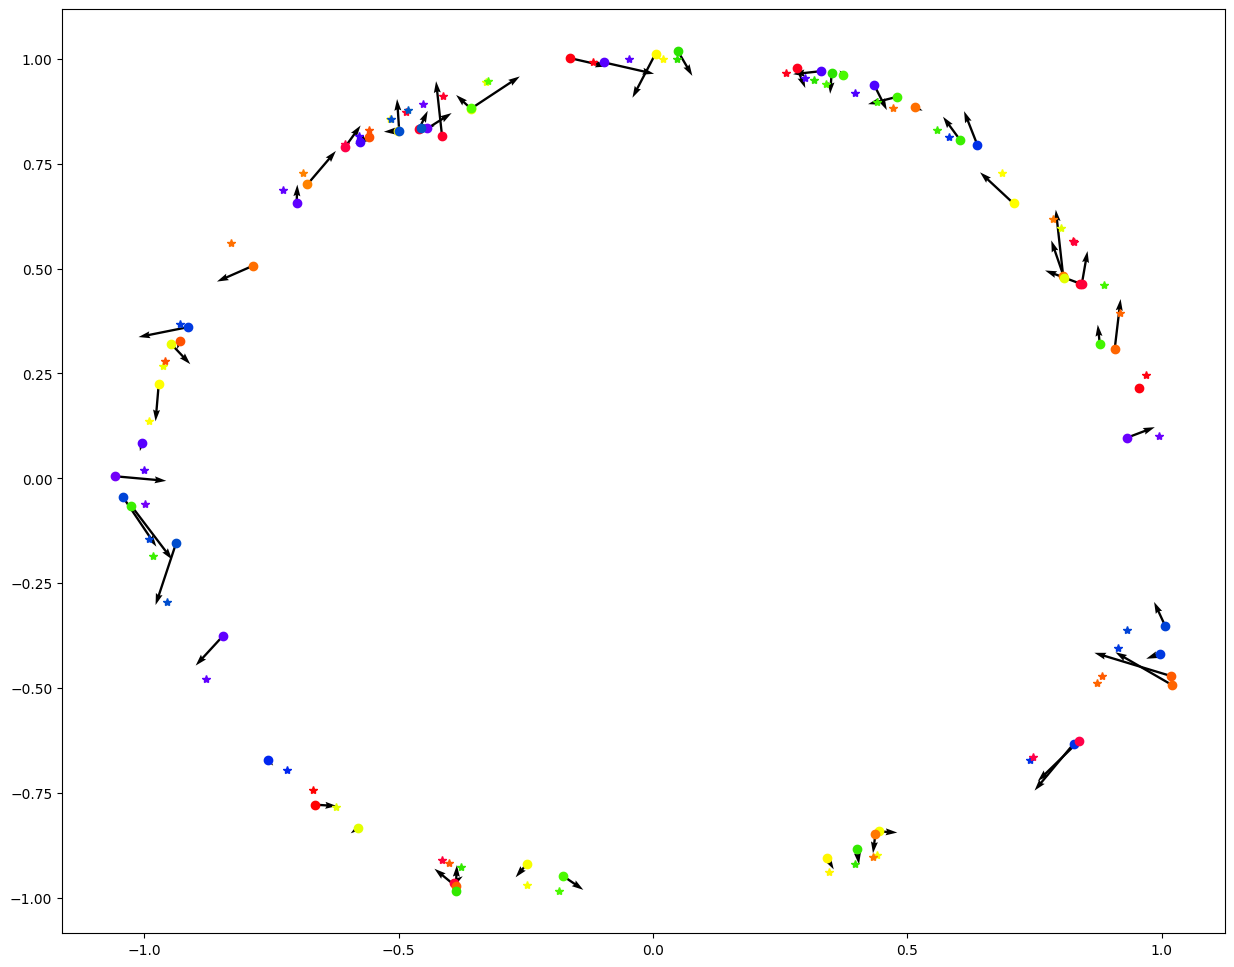

In [36]:
vis_q0(config, M, sde, params, net)

#### Multisteps with fixed discretizations

In [40]:
def train(config=None):
    # with wandb.init(config=config):
    global key
    global batch_cum_loss
    batch_cum_loss = 0
    # config = wandb.config
    print(config)

    # n_steps = config.n_steps
    # T = config.T
    # amp = config.amp
    # scale = config.scale
    # dsm_sigma = config.dsm_sigma

    # learning_rate = config.learning_rate
    # batch_size = config.batch_size
    # epochs = config.epochs
    # n_batches_per_epoch = config.n_batches_per_epoch

    n_steps = config["n_steps"]
    T = config["T"]
    amp = config["amp"]
    scale = config["scale"]
    dsm_sigma = config["dsm_sigma"]

    learning_rate = config["learning_rate"]
    batch_size = config["batch_size"]
    epochs = config["epochs"]
    n_batches_per_epoch = config["n_batches_per_epoch"]

    M = setup_manifold(config)
    Eulerian_sde = setup_sde(config, M)
    dW = lambda key: jnp.sqrt(T / n_steps) * jax.random.normal(key, (n_steps, M.N, M.N, M.m))

    def data_generator():
        global key
        while True:
            qss, tss = [], []
            for _ in range(batch_size):
                key, _ = jax.random.split(key)
                q0 = downsample_shape(M, key=key, random=False)
                (ts, qs, _) = Eulerian_sde(q0, amp, scale, dts(T, n_steps), dW(key))
                random_idx = jax.random.randint(key, shape=(1,), minval=0, maxval=n_steps)[0]
                tss.append(ts[random_idx].reshape(1, ))
                qss.append(qs[random_idx])
            (qss, tss) = map(lambda x: jnp.stack(x), (qss, tss))
            yield (qss, tss)

    ds = tf.data.Dataset.from_generator(data_generator, 
                                        output_types=tuple([tf.float32, 
                                                            tf.float32]),
                                        output_shapes=([batch_size, M.dim],
                                                       [batch_size, 1]))
    ds = iter(tfds.as_numpy(ds))
    print("Batch shape", next(ds)[0].shape)
    print("Batch shape", next(ds)[1].shape)

    net = MLP(output_dim=M.dim,
        hidden_dims=[256, 512, 512, 256],
        activation='elu')
    params = net.init(key, jnp.zeros((1, M.dim + 1)))

    def dsm_loss_func(params, data):
        global key
        (qs, ts) = data
        key, _ = jax.random.split(key)
        noises = jax.random.normal(key, shape=qs.shape) * dsm_sigma
        noisy_qs = qs + noises
        return 0.5 * jnp.mean(jnp.square(net.apply(params, jnp.hstack((noisy_qs, ts))) + noises/dsm_sigma**2))
        # return 0.5 * jnp.mean(jnp.square(net.apply(params, jnp.hstack((noisy_qs, ts)))*dsm_sigma**2 + noises))
    
    def pre_update(params, state, *args, **kwargs):
        global batch_cum_loss
        # wandb.log({"loss": state.value})
        batch_cum_loss += state.value
        if state.iter_num % (n_batches_per_epoch) == 0:
            print(f"Epoch [{state.iter_num//n_batches_per_epoch+1} / {epochs}]: avg training loss = {batch_cum_loss/n_batches_per_epoch:.4f}")
            batch_cum_loss = 0
        return params, state
    
    opt = optax.adam(learning_rate)
    solver = jaxopt.OptaxSolver(opt=opt,
                                fun=dsm_loss_func,
                                maxiter=epochs*n_batches_per_epoch,
                                pre_update=pre_update)
    
    state = solver.init_state(params, next(ds))
    params, state = solver.run_iterator(init_params=params,
                                        iterator=ds)
    
    return M, Eulerian_sde, params, net

In [41]:
config.update({"project": "shape_score",
                "name": "1.0_dsm_sigma",
                "n_landmarks": 64,
                "landmark_kernel_alpha": 1.0,
                "landmark_kernel_dim": 17,
                "amp": 0.1,
                "scale": 10.0,
                "n_steps": 10,
                "T": 1.0,
                "learning_rate": 0.0001,
                "epochs": 100,
                "batch_size": 32,
                "n_batches_per_epoch": 100,
                "dsm_sigma": 1.0})
M, sde, params, net = train(config)

{'n_landmarks': 64, 'landmark_kernel_alpha': 1.0, 'landmark_kernel_dim': 17, 'amp': 0.1, 'scale': 10.0, 'n_steps': 10, 'T': 1.0, 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'n_batches_per_epoch': 100, 'dsm_sigma': 1.0, 'project': 'shape_score', 'name': '1.0_dsm_sigma'}
Batch shape (32, 128)
Batch shape (32, 1)
Epoch [1 / 100]: avg training loss = inf
Epoch [2 / 100]: avg training loss = 0.4760
Epoch [3 / 100]: avg training loss = 0.3307
Epoch [4 / 100]: avg training loss = 0.2380
Epoch [5 / 100]: avg training loss = 0.1681
Epoch [6 / 100]: avg training loss = 0.1173
Epoch [7 / 100]: avg training loss = 0.0819
Epoch [8 / 100]: avg training loss = 0.0577
Epoch [9 / 100]: avg training loss = 0.0410
Epoch [10 / 100]: avg training loss = 0.0295
Epoch [11 / 100]: avg training loss = 0.0221
Epoch [12 / 100]: avg training loss = 0.0167
Epoch [13 / 100]: avg training loss = 0.0135
Epoch [14 / 100]: avg training loss = 0.0113
Epoch [15 / 100]: avg training loss = 0.0096
Epoch [16 /

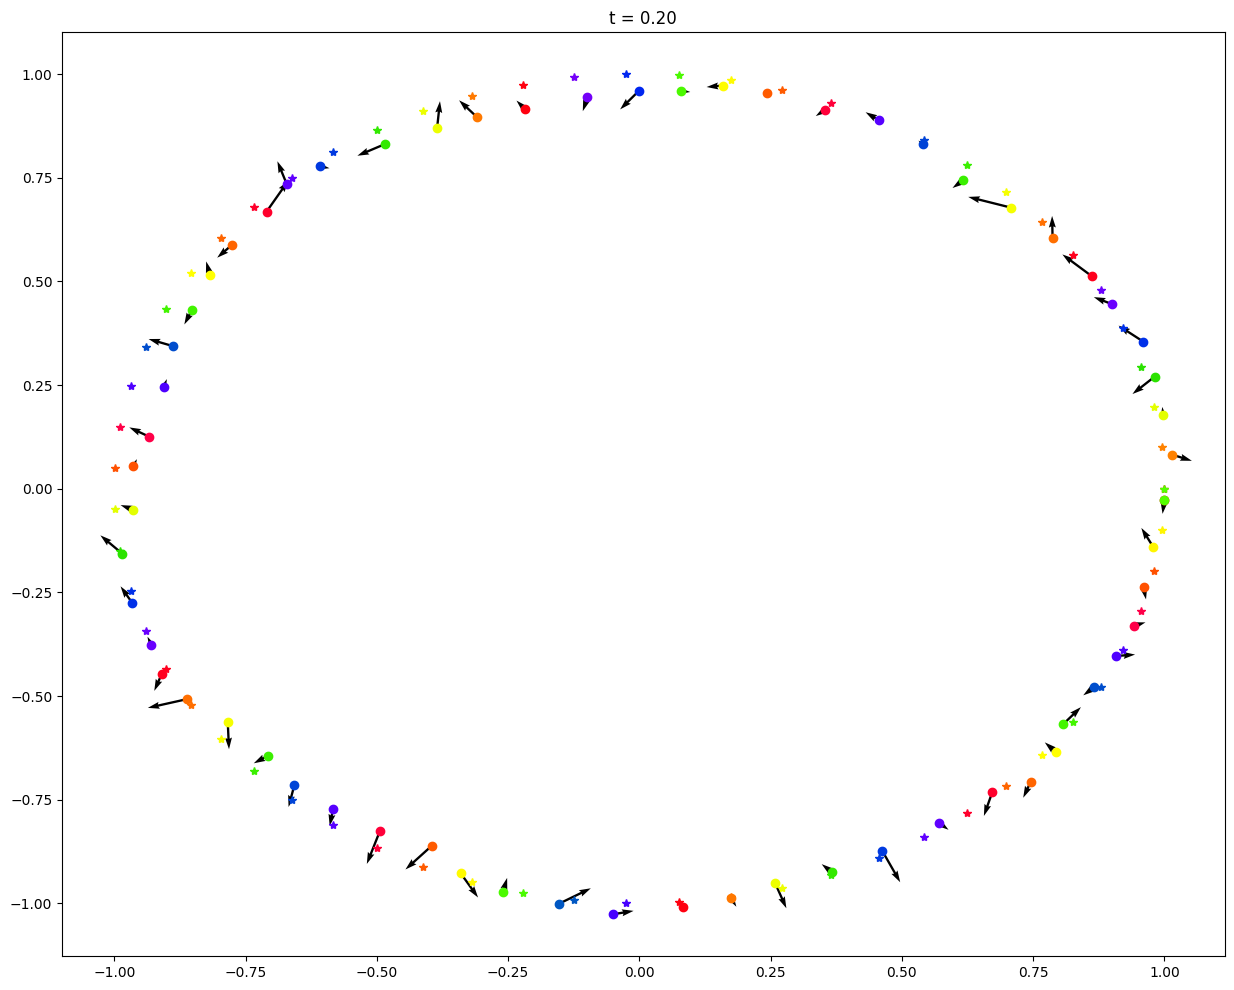

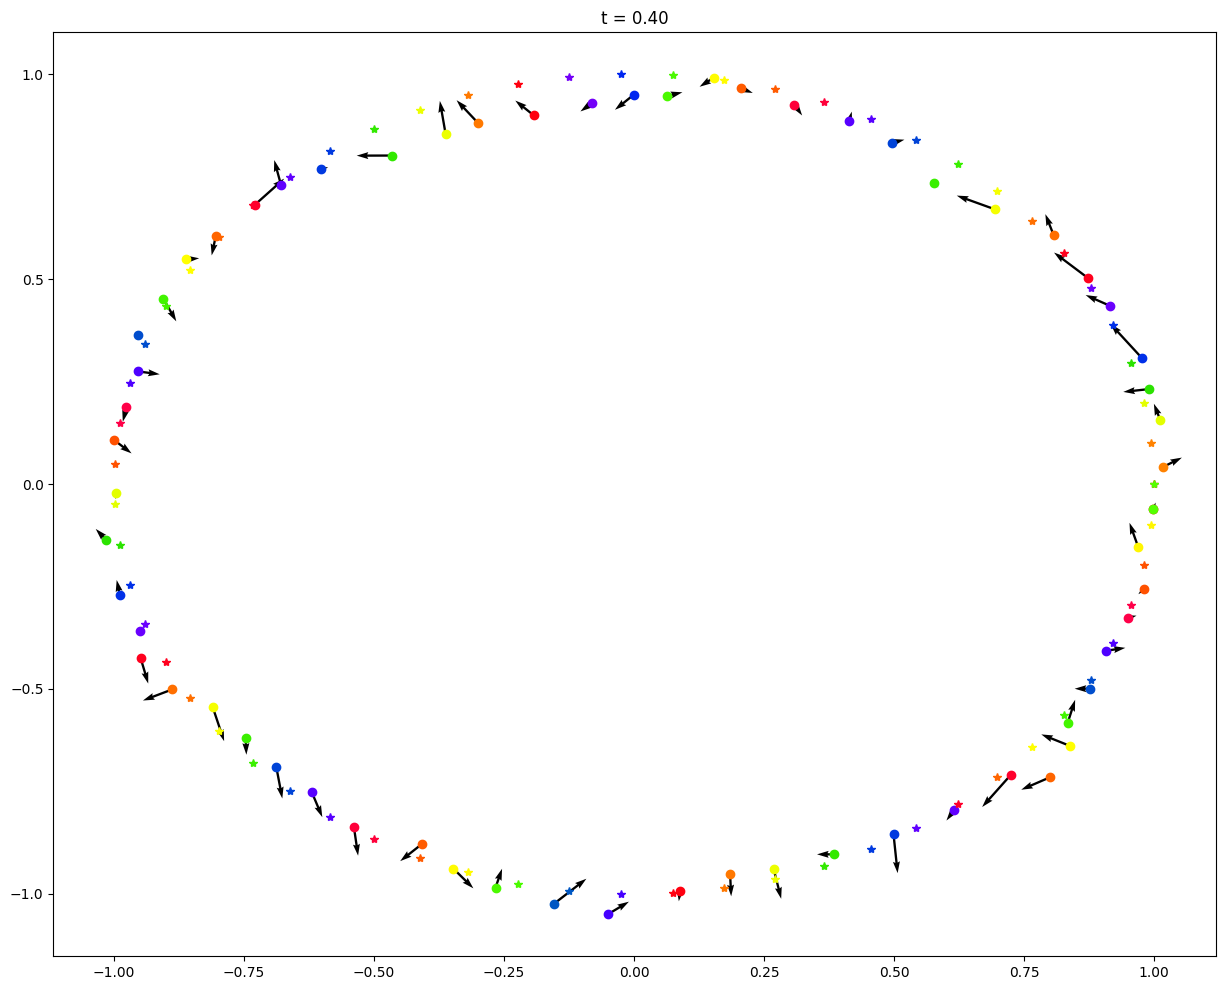

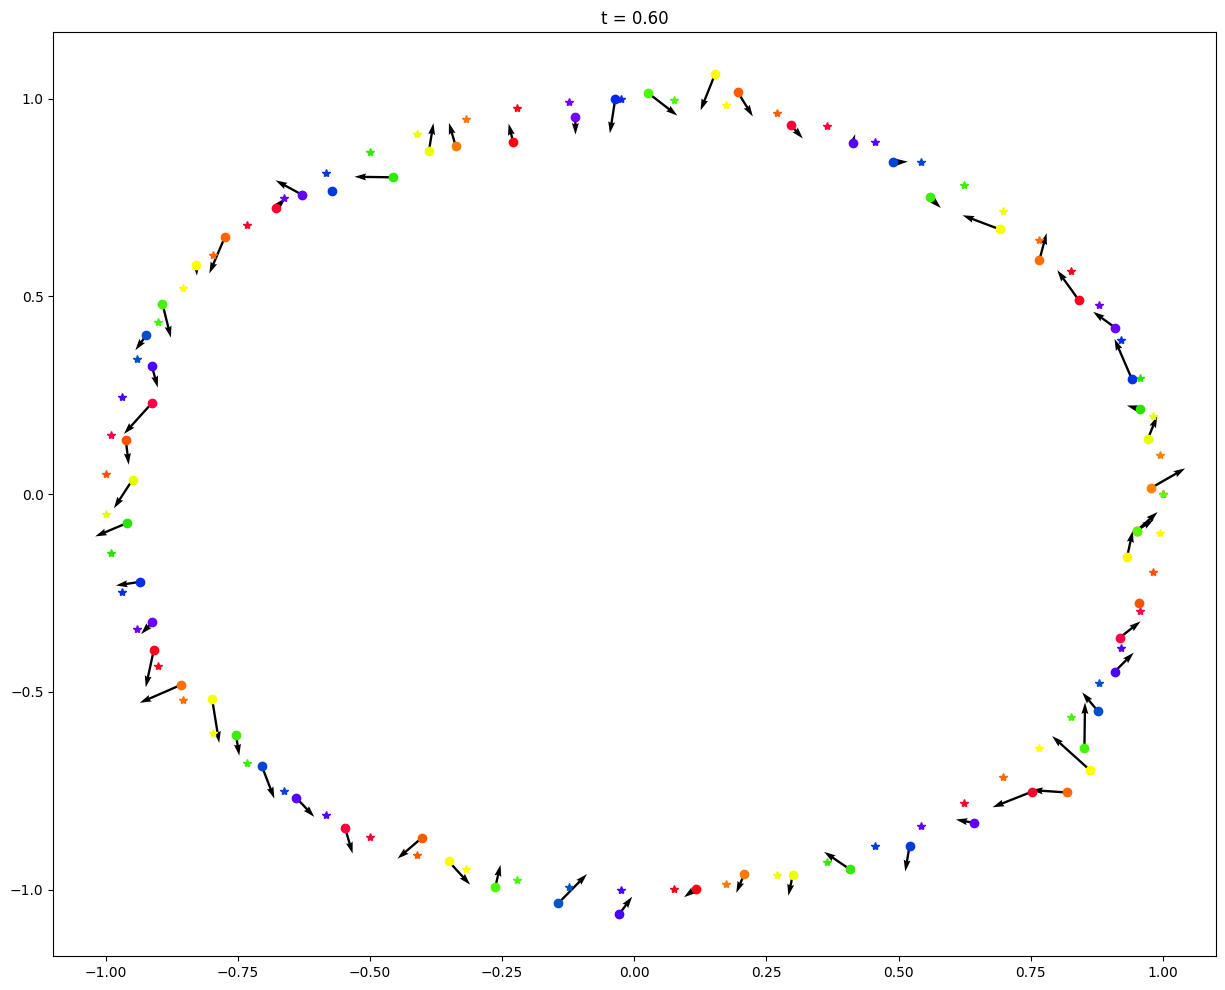

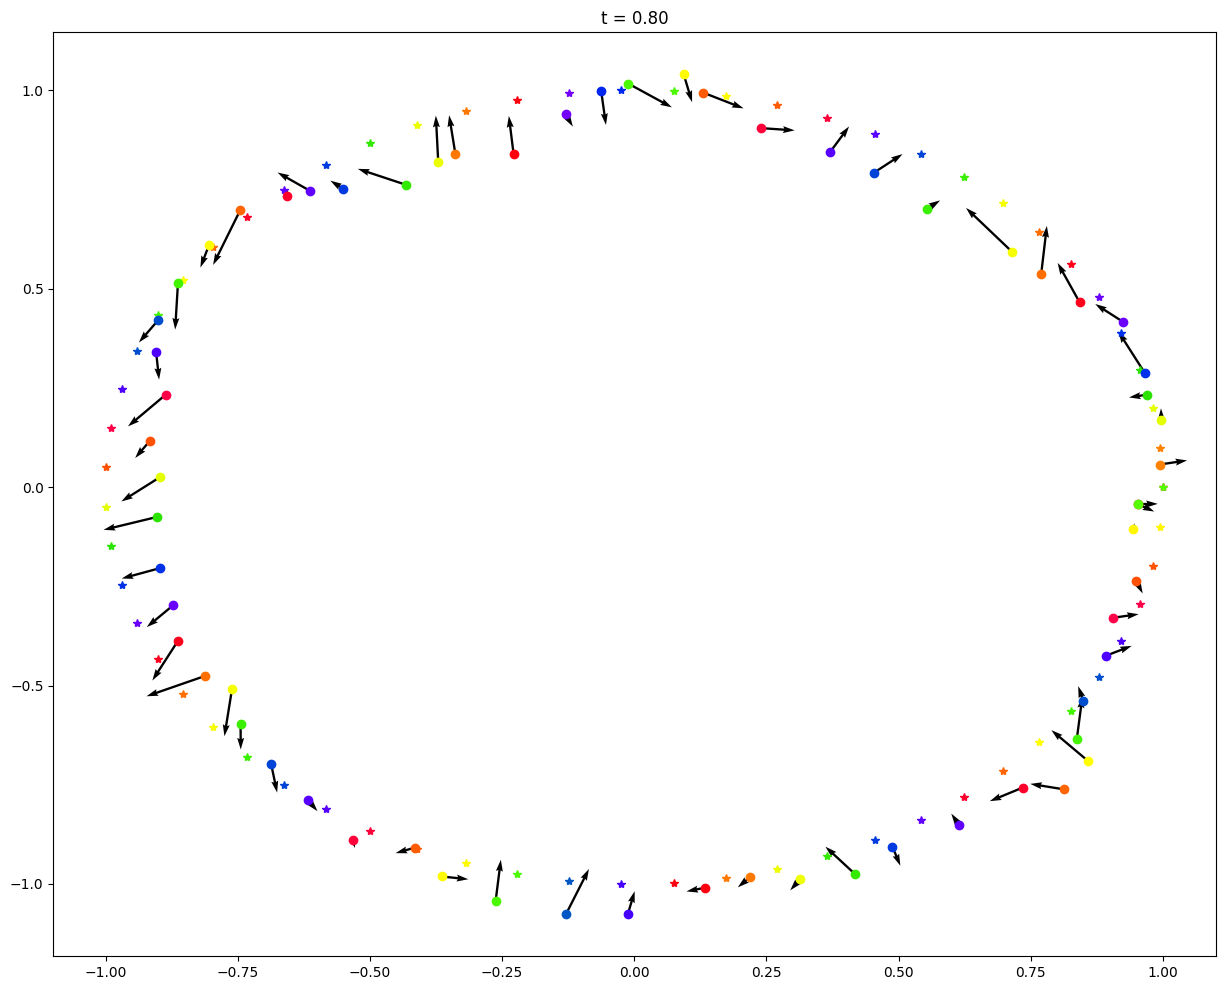

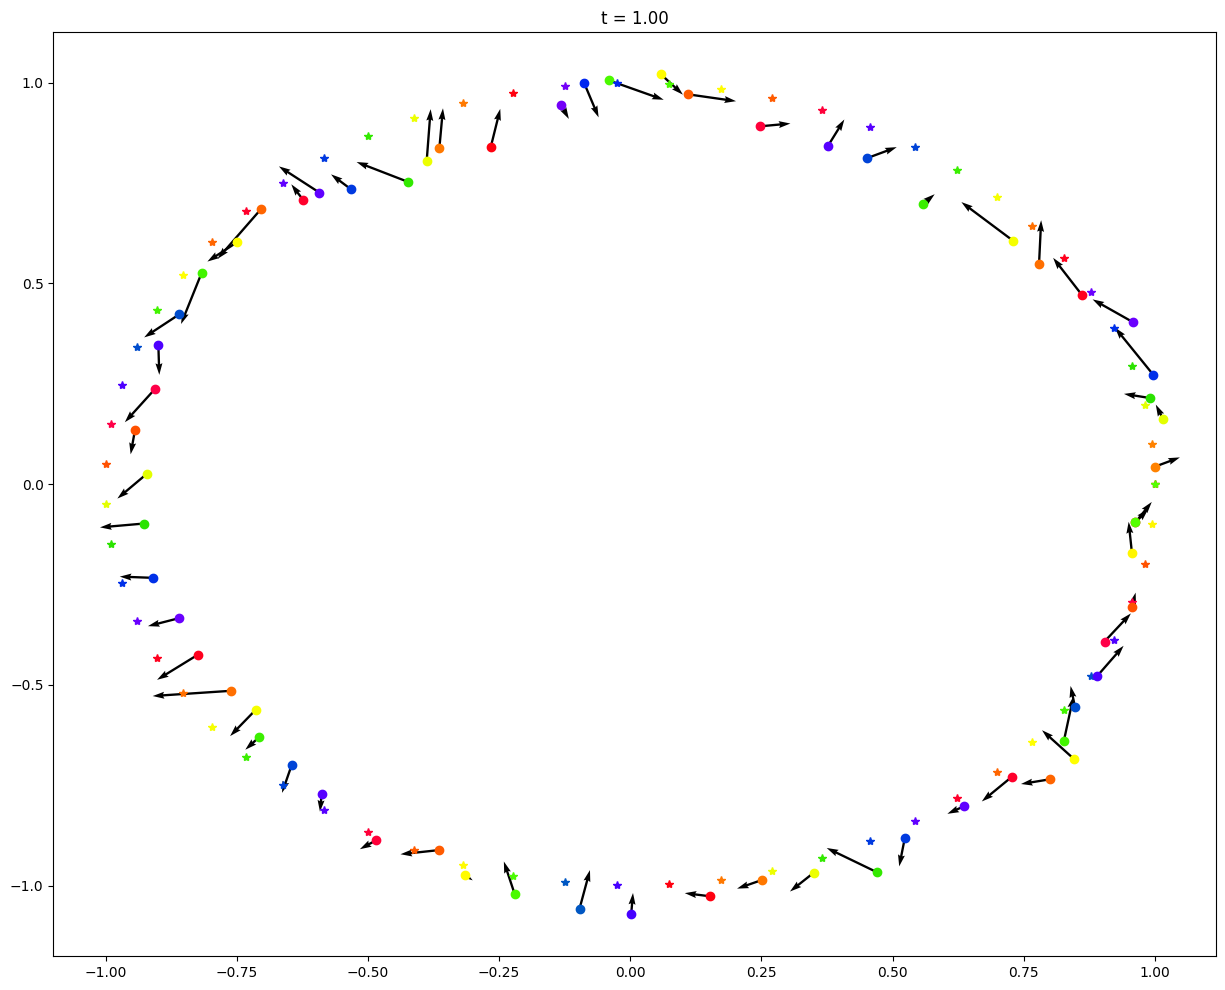

In [47]:
vis_t(config, M, sde, params, net)

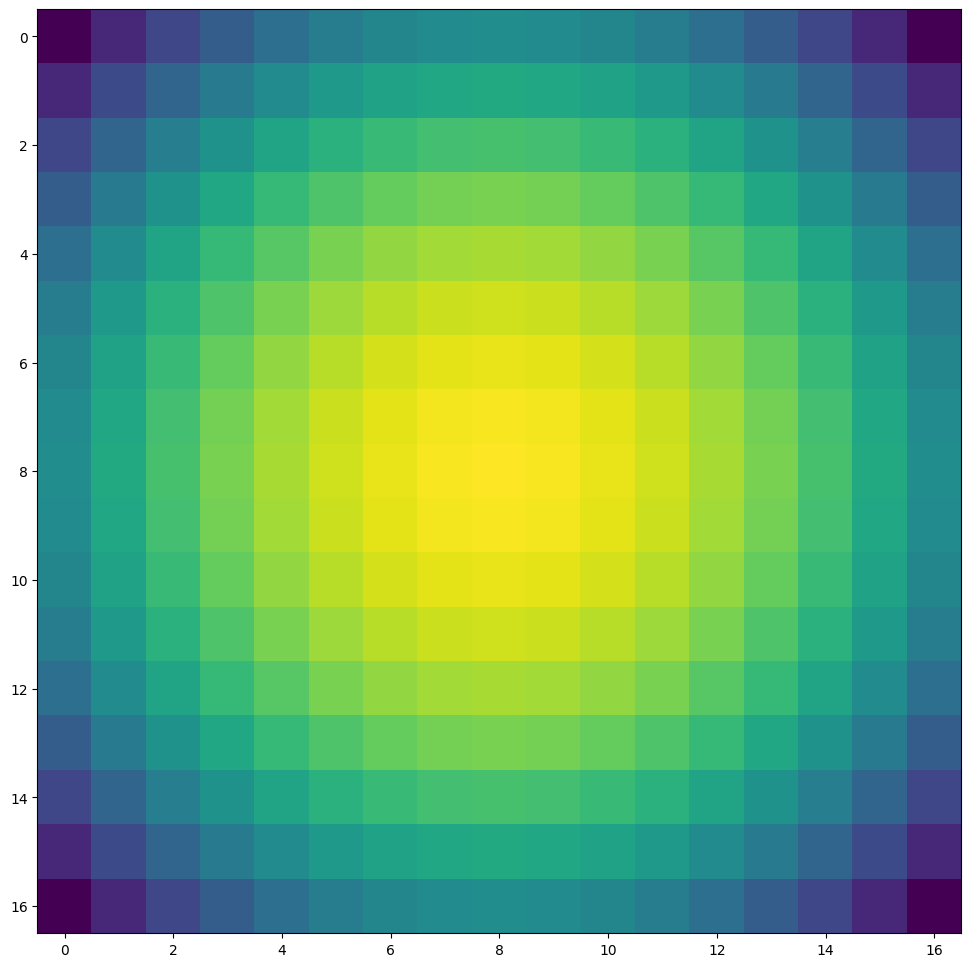

In [4]:
x = jnp.linspace(-3., 3., 17)
window = lambda amp, scale: amp * scale * jnp.sqrt(2. * jnp.pi) * jsp.stats.norm.pdf(x, loc=0., scale=scale) * jsp.stats.norm.pdf(x[:, None], loc=0., scale=scale)
amp = 1.0
scale = 10.0
plt.imshow(window(amp, scale))